In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import warnings
warnings.filterwarnings('ignore')

# Introduction of the two dataset:

- observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.
- species_info.csv - contains data about different species and their conservation status

# Examine the data/EDA(Data Cleaning, Preprocossing, Reformat, and Combine)

In [2]:
df_obs = pd.read_csv('observations.csv')
df_spec = pd.read_csv('species_info.csv')

In [3]:
df_obs

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85
...,...,...,...
23291,Croton monanthogynus,Yosemite National Park,173
23292,Otospermophilus beecheyi,Bryce National Park,130
23293,Heterotheca sessiliflora ssp. echioides,Bryce National Park,140
23294,Dicranella rufescens,Yosemite National Park,171


In [4]:
df_obs.isna().any()

scientific_name    False
park_name          False
observations       False
dtype: bool

In [5]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


In [6]:
df_obs.describe(include = 'all')

,scientific_name,park_name,observations
count,23296,23296,23296.000000
unique,5541,4,NaN
top,Holcus lanatus,Bryce National Park,NaN
freq,12,5824,NaN
mean,NaN,NaN,142.287904
std,NaN,NaN,69.890532
min,NaN,NaN,9.000000
25%,NaN,NaN,86.000000
50%,NaN,NaN,124.000000
75%,NaN,NaN,195.000000


##### df_obs's pre-check result:  By first glance, df_obs, seem to like cleaned data, and observed no abnormal 

In [7]:
df_spec.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [8]:
df_spec.isna().sum()

category                  0
scientific_name           0
common_names              0
conservation_status    5633
dtype: int64

In [9]:
df_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [10]:
df_spec.describe(include = 'all')

,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Holcus lanatus,Dicranum Moss,Species of Concern
freq,4470,3,7,161


In [11]:
# Replacing the nan to 'unknown'
df_spec['conservation_status'].replace(np.nan, 'Unknown', inplace = True)
df_spec['conservation_status'].unique()

array(['Unknown', 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

In [12]:
df_spec.isna().sum()

category               0
scientific_name        0
common_names           0
conservation_status    0
dtype: int64

In [13]:
# Remove duplicated name in df_spec, to prevent generate extra rows when left joining with df_obj
df_spec.drop_duplicates(subset=['scientific_name'],inplace = True) 
df_spec

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Unknown
1,Mammal,Bos bison,"American Bison, Bison",Unknown
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",Unknown
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",Unknown
4,Mammal,Cervus elaphus,Wapiti Or Elk,Unknown
...,...,...,...,...
5819,Vascular Plant,Solanum parishii,Parish's Nightshade,Unknown
5820,Vascular Plant,Solanum xanti,"Chaparral Nightshade, Purple Nightshade",Unknown
5821,Vascular Plant,Parthenocissus vitacea,"Thicket Creeper, Virginia Creeper, Woodbine",Unknown
5822,Vascular Plant,Vitis californica,"California Grape, California Wild Grape",Unknown


##### df_spec's precheck result: Replaced nan in coservation_status into 'Unknown'

# Combine two dataframe 

In [14]:
df = df_obs.merge(df_spec, how ='left', left_on = 'scientific_name', right_on ='scientific_name')
df.head()

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Unknown
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Unknown
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,Unknown
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,Unknown
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,Unknown


In [15]:
#make sure total rows of df(Our new df) is same as the df_obs, otherwise it will affect the statistic result if any
len(df_obs)

23296

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23296 entries, 0 to 23295
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   scientific_name      23296 non-null  object
 1   park_name            23296 non-null  object
 2   observations         23296 non-null  int64 
 3   category             23296 non-null  object
 4   common_names         23296 non-null  object
 5   conservation_status  23296 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.2+ MB


#  <mark> __Analytic objective list for the project__:
1. Which park had the most observations(Despite the conservation status)?
2. Which park had the most number of endangered species?
3. What is the distribution of conservation_status for animals?
4. Are certain types of species more likely to be endangered?
5. Is the difference between each species(category) and their conservation status are significant?

##### Objective 1, Which park had the most observations(Despite the conservation status)?

In [17]:
unique_spec_df = df.groupby(['park_name'])['observations'].sum().reset_index()
unique_spec_df

,park_name,observations
0,Bryce National Park,576025
1,Great Smoky Mountains National Park,431820
2,Yellowstone National Park,1443562
3,Yosemite National Park,863332


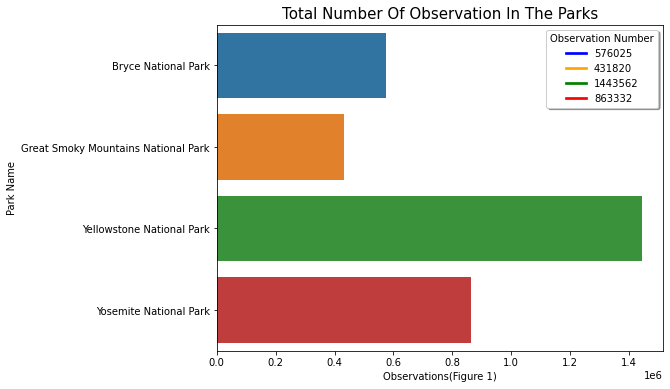

In [18]:
plt.figure(figsize=(8,6))
sns.barplot(data = unique_spec_df, y = 'park_name', x ='observations')
leg = plt.legend(labels =[576025,431820,1443562,863332], shadow = True, title ='Observation Number') #handles=['blue','orange','green','red']
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('orange')
leg.legendHandles[2].set_color('green')
leg.legendHandles[3].set_color('red')
plt.ylabel('Park Name')
plt.xlabel('Observations(Figure 1)')
plt.title('Total Number Of Observation In The Parks', fontsize = 15)
plt.show();

##### __Objective 1's Analysis Result:__
<br>
<font color ='red'>Based on the figure 1, despite conservation status and species type, we can saw that Yellowstone National Park has a richer vitality among the others among other parks.

##### Objective 2, Which park had the most number of endangered species?

In [19]:
endangered_df = df.groupby(['park_name', 'conservation_status'])['observations'].sum().reset_index()
endangered_df.head()

,park_name,conservation_status,observations
0,Bryce National Park,Endangered,489
1,Bryce National Park,In Recovery,258
2,Bryce National Park,Species of Concern,14925
3,Bryce National Park,Threatened,427
4,Bryce National Park,Unknown,559926


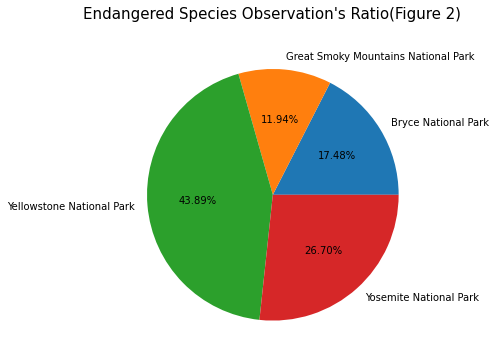

In [20]:
pie_labels = endangered_df['park_name'].unique()
pie_values= endangered_df[endangered_df['conservation_status']=='Endangered']['observations']
plt.figure(figsize = (5,5))
plt.pie(x = pie_values, labels = pie_labels, autopct = '%.2f%%')
plt.axis('equal')
plt.title('Endangered Species Observation\'s Ratio(Figure 2)', pad=40, fontsize = 15);

##### __Objective 2's Analysis Result:__
<br>
<font color = 'red'> We can see that Yellowstone National Park hold the highest ratio of endangered species among the other park from above figure 2.

##### Objective 3, What is the distribution of conservation_status for animals?

In [21]:
# reformating and subset(category: Animals only) the data tabular format by groupby function for plotting purpose.
bar_df = df.groupby(['category', 'conservation_status'])['observations'].count().reset_index()
bar_df_animal = bar_df.query('category !=["Nonvascular Plant","Vascular Plant"]')


# instead of removed the outliers of unknown status when doing plotting, I decided to scaling it down

scaler = StandardScaler()
bar_df_animal['standardscaler_observations'] = scaler.fit_transform(np.array(bar_df_animal['observations']).reshape(-1,1))
# Realized I cant use standard scaler as it will result negative, if i use Abs() function to convert it
# the distribution result is misleading


# Therefore, I decided to use numpy.log
bar_df_animal['logtransformed_observations'] = np.log(bar_df_animal['observations'])
bar_df_animal.head()

,category,conservation_status,observations,standardscaler_observations,logtransformed_observations
0,Amphibian,Endangered,4,-0.529872,1.386294
1,Amphibian,Species of Concern,16,-0.501344,2.772589
2,Amphibian,Threatened,8,-0.520363,2.079442
3,Amphibian,Unknown,292,0.154788,5.676754
4,Bird,Endangered,16,-0.501344,2.772589


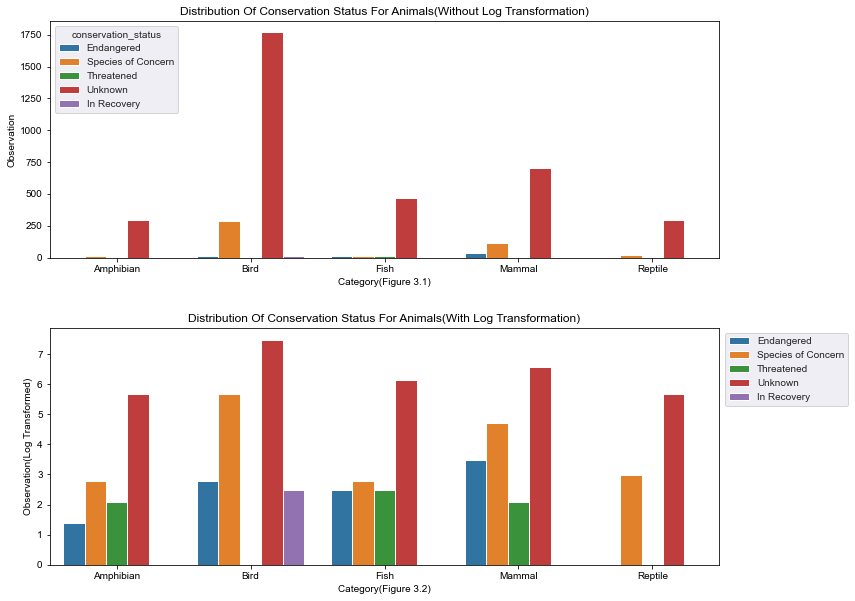

In [22]:
fig , ax = plt.subplots(2,1, figsize = (12,10))
plt.subplots_adjust(hspace = 0.3)
sns.set_style('darkgrid')

sns.barplot(data = bar_df_animal, x = 'category', y = 'observations', hue = 'conservation_status', ax = ax[0])
#ax[0].axis([0,5,0,500]) #Uncomment to zoom in
ax[0].set_title('Distribution Of Conservation Status For Animals(Without Log Transformation)')
ax[0].set_xlabel('Category(Figure 3.1)')
ax[0].set_ylabel('Observation')

sns.barplot(data = bar_df_animal, x = 'category', y = 'logtransformed_observations', hue = 'conservation_status', ax = ax[1])
ax[1].set_title('Distribution Of Conservation Status For Animals(With Log Transformation)')
plt.legend(loc = 'upper right', bbox_to_anchor= (1.2, 1));
ax[1].set_xlabel('Category(Figure 3.2)')
ax[1].set_ylabel('Observation(Log Transformed)');

##### __Objective 3's Analysis Result:__
<br>
<font color = 'red'> I subset the plant species away from the above data frame to display the distribution of conservation status of animals. Figure 3.1 is a bar graph without log-transformed, we saw that most of the data were contributed by unknown status. Therefore, I use log-transformed to convert the all status's observation values into a smaller scale and reduce the skewness affected by unknown status. 
<br><br>    
From figure 3.2 and the angle of conservation status, we knew that bird species had the highest ratio in the status of 'Species of Concern', followed by mammal species in the 'Endangered', fish species in the 'Threatened'.


##### Objective 4, Are certain types of species more likely to be endangered?

In [23]:
df['conservation_status'].unique()

array(['Unknown', 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

In [24]:
likely_endanger_df =  df.groupby(['category','conservation_status','scientific_name'])['observations'].sum().reset_index()
likely_endanger_df =likely_endanger_df.query('conservation_status =="Threatened"')\
                        .sort_values(by='category').reset_index(drop=True)
likely_endanger_df

,category,conservation_status,scientific_name,observations
0,Amphibian,Threatened,Anaxyrus canorus,274
1,Amphibian,Threatened,Rana draytonii,290
2,Fish,Threatened,Erimonax monachus,242
3,Fish,Threatened,Noturus flavipinnis,289
4,Fish,Threatened,Oncorhynchus clarkii henshawi,301
5,Mammal,Threatened,Myotis septentrionalis,302
6,Mammal,Threatened,Ursus arctos horribilis,276
7,Vascular Plant,Threatened,Isotria medeoloides,274
8,Vascular Plant,Threatened,Spiraea virginiana,278


In [25]:
likely_endanger_df['category'].unique()

array(['Amphibian', 'Fish', 'Mammal', 'Vascular Plant'], dtype=object)

In [26]:
likely_endanger_df['scientific_name'].unique()

array(['Anaxyrus canorus', 'Rana draytonii', 'Erimonax monachus',
       'Noturus flavipinnis', 'Oncorhynchus clarkii henshawi',
       'Myotis septentrionalis', 'Ursus arctos horribilis',
       'Isotria medeoloides', 'Spiraea virginiana'], dtype=object)

##### __Objective 4's Analysis Result:__
<br>
<font color = 'red'> The above tabular data show there are four type of species ['Amphibian', 'Fish', 'Mammal', 'Vascular Plant'] which likely to be classify as endangered in future if no action is taken. Here are the list of species being classified as 'Threathened' as below:
    <br>
- 2 x Amphibian type(Anaxyrus canorus, Rana draytonii)
    <br>
- 3 x Fish type(Rana draytonii, Noturus flavipinnis, Oncorhynchus clarkii henshawi)
    <br>
- 2 x Mammal type(Myotis septentrionalis, Ursus arctos horribilis)
    <br>
- 2 x Vascular Plant(Isotria medeoloides, Spiraea virginiana)

##### Objective 5, is the difference between each species(category) and their conservation status are significant?

In [27]:
diff_spec_status = df.groupby(['category','conservation_status'])['observations'].sum().reset_index()
diff_spec_status

,category,conservation_status,observations
0,Amphibian,Endangered,144
1,Amphibian,Species of Concern,2044
2,Amphibian,Threatened,564
3,Amphibian,Unknown,41219
4,Bird,Endangered,574
5,Bird,In Recovery,1392
6,Bird,Species of Concern,36642
7,Bird,Unknown,254225
8,Fish,Endangered,455
9,Fish,Species of Concern,2109


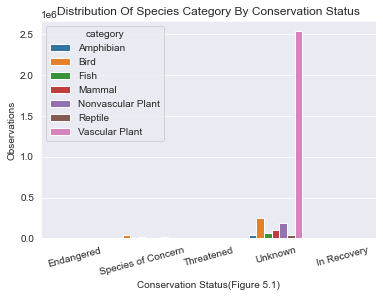

In [28]:
sns.barplot(data = diff_spec_status, x= 'conservation_status', y = 'observations', hue = 'category')
plt.xlabel('Conservation Status(Figure 5.1)')
plt.ylabel('Observations')
plt.title('Distribution Of Species Category By Conservation Status')
plt.xticks(rotation = 15);

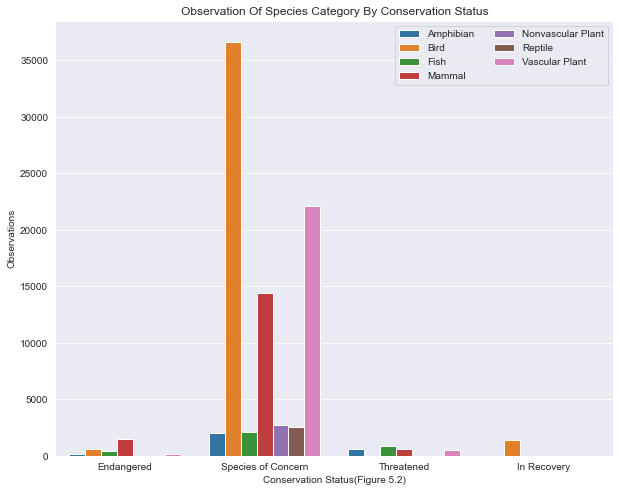

In [29]:
# 'Unknown' status is not really related to this question, and it's contained an imbalance ratio of observations number to 
#  other conservation status. Therefore, I decided to remove it.
plt.figure(figsize=(10,8))
subset_unknown = diff_spec_status.query('conservation_status != "Unknown"')
sns.barplot(data = subset_unknown, x= 'conservation_status', y = 'observations', hue = 'category')
plt.legend(ncol = 2, loc = 'upper right')
plt.xlabel('Conservation Status(Figure 5.2)')
plt.ylabel('Observations')
plt.title('Observation Of Species Category By Conservation Status');

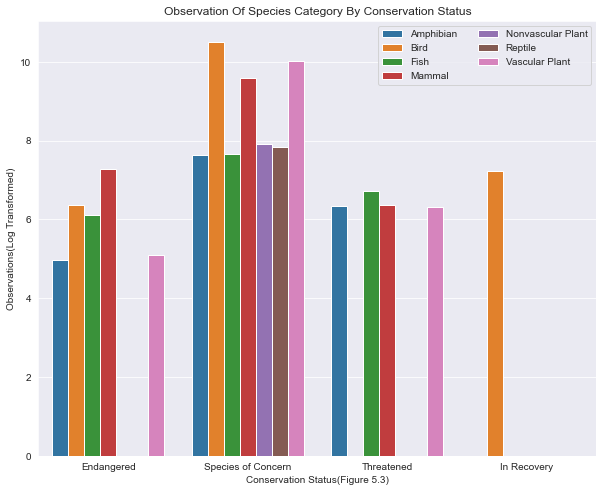

In [30]:
subset_unknown['log_transformed_obs'] = np.log(subset_unknown['observations'])
plt.figure(figsize = (10,8))
sns.barplot(data = subset_unknown, x= 'conservation_status', y = 'log_transformed_obs', hue = 'category')
plt.legend(ncol = 2, loc = 'upper right')
plt.xlabel('Conservation Status(Figure 5.3)')
plt.ylabel('Observations(Log Transformed)')
plt.title('Observation Of Species Category By Conservation Status');

In [31]:
def tukey_test(category_name):
    new_df = df[(df['category']== category_name)]
    
    print(pairwise_tukeyhsd(new_df['observations'], new_df['conservation_status'], 0.05))
    print('\n\n')

In [32]:
for i in range(len(df['category'].unique())):
    print('Category Name: ' + df['category'].unique()[i])
    tukey_test(df['category'].unique()[i])

Category Name: Vascular Plant
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1             group2       meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------------------
        Endangered Species of Concern  88.1919 0.0603   -2.5072 178.8909  False
        Endangered         Threatened     28.5    0.9  -81.3136 138.3136  False
        Endangered            Unknown 102.5968 0.0173   12.9242 192.2694   True
Species of Concern         Threatened -59.6919 0.0842 -124.5505   5.1668  False
Species of Concern            Unknown  14.4049 0.0356    0.6653  28.1446   True
        Threatened            Unknown  74.0968 0.0143   10.6815 137.5121   True
-------------------------------------------------------------------------------



Category Name: Mammal
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1             group2       meandiff p-adj    lower    

##### __Objective 5's Analysis Result:__
<br>
<font color = 'red'> By looking at the figure from 5.1 to 5.3. It seems like there is a significant difference between species and their conservation status. However, we need some scientific method to justify hypothesis rather than judging by intuitive.
    <br><br>
Since there are non-binary categorical variables ('Conservation status of each species)and quantitative variable('Observation number'), I decided to perform a Tukey test on all species and their conservation status with for-loop.
<br><br>
The Tukey test results show almost every species are a significant difference between species and its conservation status except 'Reptile'. The main reason is the limited data on the reptile category with only two conservation statuses.